Data retrieved from frost.met.no!
                        elementId  value  unit timeOffset timeResolution  \
0       mean(air_temperature P1D)    3.2  degC       PT0H            P1D   
1       mean(air_temperature P1D)    3.0  degC       PT6H            P1D   
2   sum(precipitation_amount P1D)   13.5    mm      PT18H            P1D   
3   sum(precipitation_amount P1D)   29.0    mm       PT6H            P1D   
4            mean(wind_speed P1D)    1.7   m/s       PT0H            P1D   
5       mean(air_temperature P1D)    3.0  degC       PT0H            P1D   
6       mean(air_temperature P1D)    3.2  degC       PT6H            P1D   
7   sum(precipitation_amount P1D)    3.3    mm      PT18H            P1D   
8   sum(precipitation_amount P1D)    9.0    mm       PT6H            P1D   
9            mean(wind_speed P1D)    2.9   m/s       PT0H            P1D   
10      mean(air_temperature P1D)    2.1  degC       PT0H            P1D   
11      mean(air_temperature P1D)   -0.9  degC       P

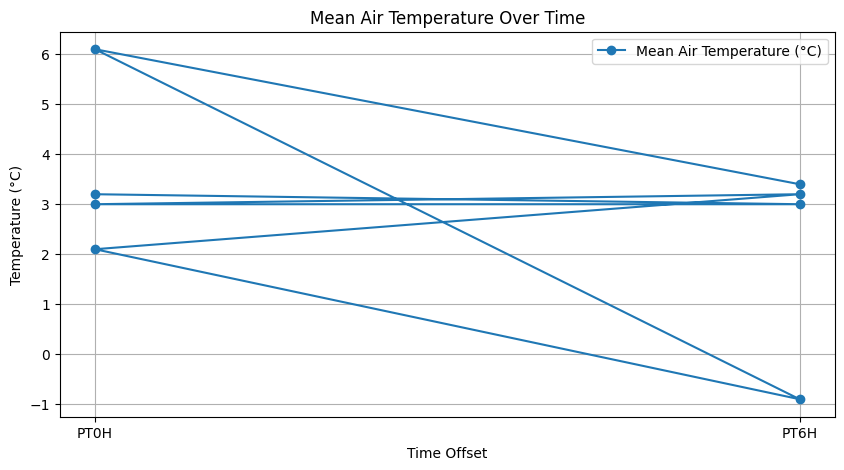

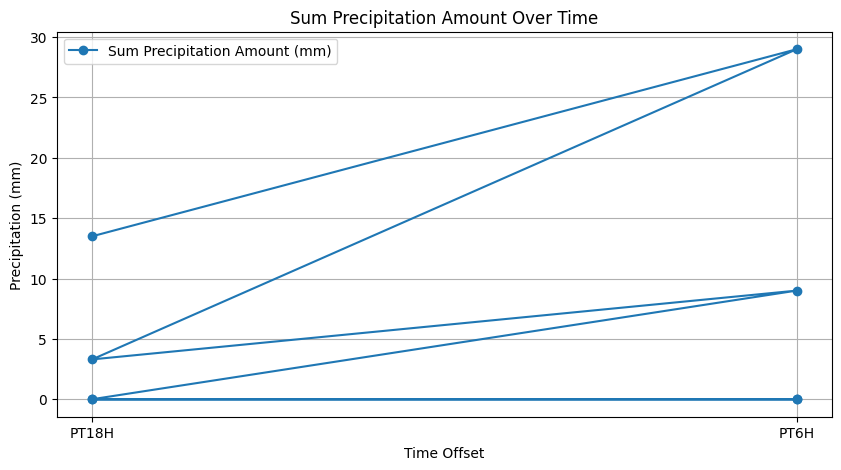

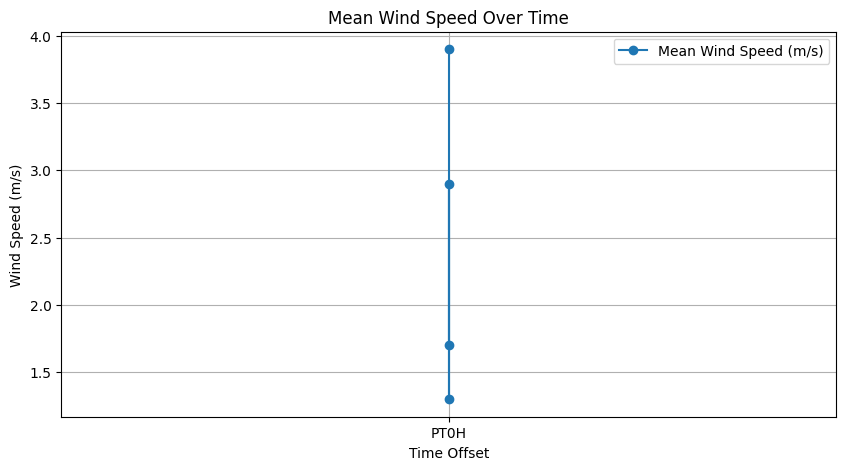

In [33]:
# Libraries needed (pandas is not standard and must be installed in Python)
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Insert your own client ID here
client_id = '2e243d34-57bc-42b4-8095-239991af5353'
# Define endpoint and parameters
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': 'SN18700,SN90450',
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)',
    'referencetime': '2010-04-01/2010-04-03',
}
# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(client_id,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

important_keys = ['elementId', 'value', 'unit', 'timeOffset', 'timeResolution', 'qualityCode']

# Collect the important data into a list of dictionaries
observations_list = []
for item in data:
    observations = item.get('observations', [])
    for observation in observations:
        important_data = {key: observation[key] for key in important_keys if key in observation}
        observations_list.append(important_data)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(observations_list)

# Display the DataFrame
print(df)

# Plotting the data
# Separate the data by elementId
temperature_data = df[df['elementId'] == 'mean(air_temperature P1D)']
precipitation_data = df[df['elementId'] == 'sum(precipitation_amount P1D)']
wind_speed_data = df[df['elementId'] == 'mean(wind_speed P1D)']

# Plot mean air temperature
plt.figure(figsize=(10, 5))
plt.plot(temperature_data['timeOffset'], temperature_data['value'], marker='o', label='Mean Air Temperature (°C)')
plt.xlabel('Time Offset')
plt.ylabel('Temperature (°C)')
plt.title('Mean Air Temperature Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot sum precipitation amount
plt.figure(figsize=(10, 5))
plt.plot(precipitation_data['timeOffset'], precipitation_data['value'], marker='o', label='Sum Precipitation Amount (mm)')
plt.xlabel('Time Offset')
plt.ylabel('Precipitation (mm)')
plt.title('Sum Precipitation Amount Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot mean wind speed
plt.figure(figsize=(10, 5))
plt.plot(wind_speed_data['timeOffset'], wind_speed_data['value'], marker='o', label='Mean Wind Speed (m/s)')
plt.xlabel('Time Offset')
plt.ylabel('Wind Speed (m/s)')
plt.title('Mean Wind Speed Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
df_list = []

for item in data:
    row = pd.DataFrame(item['observations'])
    row['referenceTime'] = item['referenceTime']
    row['sourceId'] = item['sourceId']
    df_list.append(row)

# Efficiently concatenate all DataFrames at once
df = pd.concat(df_list, ignore_index=True)

df.head()

,elementId,value,unit,level,timeOffset,timeResolution,timeSeriesId,performanceCategory,exposureCategory,qualityCode,referenceTime,sourceId
0,mean(air_temperature P1D),3.2,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,2,2010-04-01T00:00:00.000Z,SN18700:0
1,mean(air_temperature P1D),3.0,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT6H,P1D,0,C,2,2,2010-04-01T00:00:00.000Z,SN18700:0
2,sum(precipitation_amount P1D),13.5,mm,NaN,PT18H,P1D,0,C,2,2,2010-04-01T00:00:00.000Z,SN18700:0
3,sum(precipitation_amount P1D),29.0,mm,NaN,PT6H,P1D,0,C,2,2,2010-04-01T00:00:00.000Z,SN18700:0
4,mean(wind_speed P1D),1.7,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,2,2010-04-01T00:00:00.000Z,SN18700:0
